# データラングリング & 探索的データ解析

この演習では，食料品即日配達サービス[Instacart](https://www.instacart.com)の注文データを用いる．演習を開始する前に，[データダウンロードリンク](https://www.instacart.com/datasets/grocery-shopping-2017)よりデータが納められたzipファイル（約200MB）をダウンロードしておくこと．

ダウンロードしたzipファイルには下記6つのcsvファイルが圧縮されている．
* ``departments.csv``: 商品売り場（カテゴリ）に関するデータ（21件）
* ``aisles.csv``: 商品棚（サブカテゴリ）に関するデータ（134件）
* ``products.csv``: 商品に関するデータ（約5万件）
* ``orders.csv``: 注文に関するデータ（約20万6000ユーザによる約340万件の注文）
* ``order_products__train.csv``: 各Instacartユーザが最も最近行った注文の明細データ
* ``order_products__prior.csv``: 各Instacartユーザが過去に行った注文の明細データ（最も最近の注文を除く）

各csvファイルの詳細は，``data/instacart``ディレクトリの``data-recipe.md``ファイルで確認することができる．

### Q1. データベース作成
ダウンロードしたcsvファイル内のデータをSQLiteのデータベースに格納せよ．テーブル名は``department``のように，csvファイル名から拡張子を取り除いたものにせよ．ただし，``order_products__train.csv``と``order_products__prior.csv``のデータについては，``order_products``というテーブルを作成し，そこにデータを格納せよ．カラム情報は``data/instacart``ディレクトリの``data-recipe.md``ファイルに記した内容に従うこと．

なお，必要であれば，``data/instacart``ディレクトリの``init_sqlite.sql``ファイルを利用してもよい．

### Q2. pandasデータフレームへの読み込み
``pandas``ライブラリの``read_sql``関数を用いると，SQLite上にあるデータベースにSQLを発行し，その結果を``pandas.DataFrame``データフレームに読み出すことができる．下記コードは，SQLite上にある``instacart``データベースの``department``テーブルの内容をデータフレームに読み込む例である．

``products``テーブル，``aisles``テーブル，``departments``テーブル，``orders``テーブル，``order_products``テーブルのレコード数を調べるSQL文を発行し，各テーブルのレコード数を表示せよ．

In [1]:
import sqlite3
import pandas as pd
import pandas.io.sql as psql

In [2]:
db = sqlite3.connect('../data/instacart/instacart.db') # DBと接続する
sql = "SELECT * FROM departments;"
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）

# 最初の5件を表示
df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [3]:
db = sqlite3.connect('../data/instacart/instacart.db') # DBと接続する

# departmentsテーブル
sql = "SELECT COUNT(*) AS record_num FROM departments;"
df = psql.read_sql(sql, db)
print("#departments = ", df['record_num'].values[0])

# aislesテーブル
sql = "SELECT COUNT(*) AS record_num FROM aisles;"
df = psql.read_sql(sql, db)
print("#aisles = ", df['record_num'].values[0])

# productsテーブル
sql = "SELECT COUNT(*) AS record_num FROM products;"
df = psql.read_sql(sql, db)
print("#products = ", df['record_num'].values[0])

# ordersテーブル
sql = "SELECT COUNT(*) AS record_num FROM orders;"
df = psql.read_sql(sql, db)
print("#orders = ", df['record_num'].values[0])

# order_productsテーブル
sql = "SELECT COUNT(*) AS record_num FROM order_products;"
df = psql.read_sql(sql, db)
print("#order_products = ", df['record_num'].values[0])

# DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）
db.close() 


#departments =  21
#aisles =  134
#products =  49688
#orders =  3421083
#order_products =  33819106


### Q3. マスターデータ作成（テーブル結合 & 集約演算）
商品部門別および商品棚別に商品数を求めるSQL文を発行し，その結果をデータフレーム形式で表示せよ．なお，表示するデータフレームは下記の形式とせよ．また表示する結果は，商品数の降順でソートしたものとせよ．

| |department |aisle |iterm_count|
|---: |---:|---:|---:|
|0 |personal care |ALL |6563 |
|... |... |... |... |

In [4]:
db = sqlite3.connect('../data/instacart/instacart.db')
sql = """
SELECT
    d.department_id,
    d.department,
    a.aisle,
    COUNT(*) AS item_num
FROM
    products p
    JOIN departments d USING(department_id)    
    JOIN aisles a USING(aisle_id)
GROUP BY
    d.department_id, a.aisle_id
UNION ALL
SELECT 
    d.department_id,
    d.department,
    'ALL' AS aisle,
    COUNT(*) AS item_num
FROM
    products p
    JOIN departments d USING(department_id)
GROUP BY
    d.department_id
ORDER BY
    item_num DESC
"""

# MySQLであればROOLUPオプションが利用可能
# sql = """
# SELECT 
#     a.aisle,
#     d.department,
#     COUNT(*) AS item_num
# FROM
#     products p
#     JOIN aisles a USING(aisle_id)
#     JOIN departments d USING(department_id)
# GROUP BY
#     d.department_id, a.aisle_id WITH ROLLUP
# ORDER BY
#     item_num DESC
# """

df = psql.read_sql(sql, db)
db.close()

In [5]:
df

,department_id,department,aisle,item_num
0,11,personal care,ALL,6563
1,19,snacks,ALL,6264
2,13,pantry,ALL,5371
3,7,beverages,ALL,4365
4,1,frozen,ALL,4007
...,...,...,...,...
150,18,babies,baby accessories,44
151,10,bulk,ALL,38
152,4,produce,packaged produce,32
153,10,bulk,bulk grains rice dried goods,26


### Q4. 注文行動に関する基礎情報（集約演算2）
ユーザID毎に注文回数（``order_frequency``）および注文の平均間隔（``avg_order_interval``）を把握したい．注文回数が10回以上99以下のユーザに関して，ユーザID毎の注文回数と注文平均間隔を求めるSQL文を発行し，注文平均間隔の上位10件（昇順）のユーザ情報のみ表示せよ．結果はデータフレーム形式で表示せよ．

In [6]:
db = sqlite3.connect('../data/instacart/instacart.db') # DBと接続する
sql = """
SELECT
    user_id,
    MAX(order_number) AS order_frequency,
    AVG(days_since_prior) AS avg_order_interval
FROM
    orders
GROUP BY
    user_id
HAVING 
    order_frequency BETWEEN 10 AND 99
ORDER BY
    avg_order_interval ASC
LIMIT 10
"""
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）

In [7]:
# 最初の10件を表示
df.head(10)

,user_id,order_frequency,avg_order_interval
0,88589,27,0.518519
1,58157,48,0.604167
2,31834,11,0.818182
3,204214,23,0.826087
4,190812,16,0.875000
5,309,26,0.961538
6,15963,10,1.000000
7,68345,10,1.000000
8,175931,42,1.000000
9,192717,10,1.000000


### Q5. 注文タイミング（ヒートマップによる可視化）
注文があった曜日および時間帯別（例: 土曜日の23時）の注文総数を集計するSQL文を発行し，その結果をヒートマップ形式で表示せよ．

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline

In [9]:
db = sqlite3.connect('../data/instacart/instacart.db')
sql = """
SELECT
    order_dow AS day,
    order_hour_of_day AS hour,
    COUNT(*) AS order_freq
FROM
    orders
GROUP BY
    order_dow, order_hour_of_day
"""
df = psql.read_sql(sql, db)
db.close()

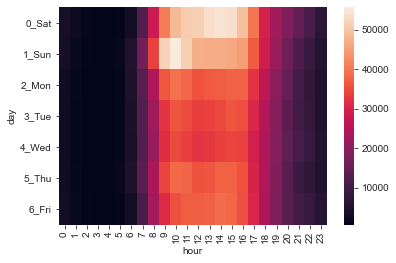

In [10]:
# 曜日の数字表記を変換
id2day = {0:'0_Sat', 1:'1_Sun', 2:'2_Mon', 3:'3_Tue', 4:'4_Wed', 5:'5_Thu', 6:'6_Fri'}
df['day'] = df['day'].apply(lambda x: id2day[x])

# 整然データ形式からピボットテーブル形式のデータに
pt = df.pivot_table(values='order_freq', index='day', columns='hour')
sns.heatmap(pt)

### Q6. 注文間隔（棒グラフによる可視化）
前回の注文からの経過日数別に注文数を集計するSQL文を発行し，その結果を棒グラフで示せ．

In [11]:
db = sqlite3.connect('../data/instacart/instacart.db')
sql = """
SELECT
    days_since_prior,
    COUNT(*) AS order_frequency
FROM
    orders
WHERE
    days_since_prior != ''
    AND days_since_prior IS NOT NULL
GROUP BY
    days_since_prior
"""
df = psql.read_sql(sql, db)
db.close()

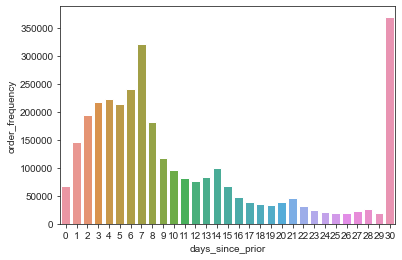

In [12]:
plt.figure(figsize=(6, 4))
fig = sns.barplot(x="days_since_prior", y="order_frequency", data=df)

### Q7. ユーザの利用頻度（副問い合わせ）
顧客の注文回数を集計することで注文回数別の顧客数を求めるSQL文を発行し，その結果を棒グラフで表示せよ．

In [13]:
db = sqlite3.connect('../data/instacart/instacart.db')
sql = """
SELECT
    tmp.order_frequency,
    COUNT(*) AS number_of_customers
FROM (
    SELECT
        user_id,
        MAX(order_number) AS order_frequency
    FROM
        orders
    GROUP BY
        user_id) tmp
GROUP BY
    tmp.order_frequency
ORDER BY
    number_of_customers
"""
df = psql.read_sql(sql, db)
db.close()

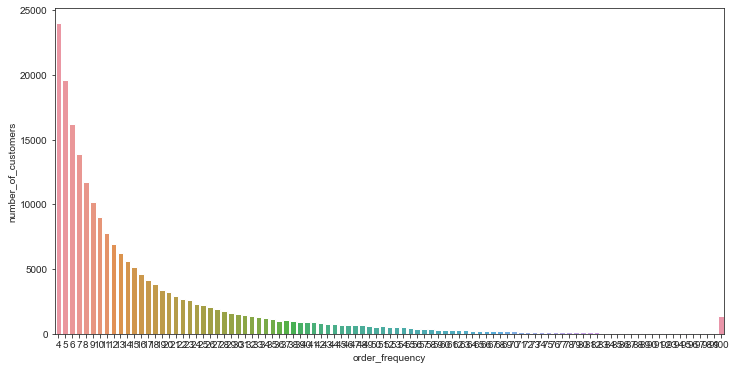

In [14]:
plt.figure(figsize=(12, 6))
fig = sns.barplot(x="order_frequency", y="number_of_customers", data=df)

### Q8. 再注文率（SQL上での算術演算）
商品売り場別の商品の注文総数および再注文率を計算するSQL文を発行し，その結果を表示せよ．なお，結果は再注文率でソートしたものを表示せよ．

In [15]:
db = sqlite3.connect('../data/instacart/instacart.db')
sql = """
SELECT
    d.department,
    COUNT(*) AS total_order_count,
    CAST(SUM(op.reordered) as float) / COUNT(*) AS reorder_rate
FROM
    order_products op
    JOIN products p USING(product_id)
    JOIN departments d USING(department_id)
GROUP BY
    department_id
ORDER BY
    reorder_rate DESC
"""
df = psql.read_sql(sql, db)
db.close()

In [16]:
df

,department,total_order_count,reorder_rate
0,dairy eggs,5631067,0.670161
1,beverages,2804175,0.653651
2,produce,9888378,0.650521
3,bakery,1225181,0.628381
4,deli,1095540,0.608130
5,pets,102221,0.602557
6,babies,438743,0.577680
7,bulk,35932,0.577090
8,snacks,3006412,0.574464
9,alcohol,159294,0.571221


### Q9. 商品棚にみる注文回数の分布（Window関数で四分位数を求める）
"pantry"売り場の商品棚別に注文回数の四分位数を求めるSQL文を発行し，その結果をデータフレームに格納し表示せよ．

In [17]:
db = sqlite3.connect('../data/instacart/instacart.db')
sql = """
SELECT
    quartiles.aisle,
    quartiles.quartile,
    MAX(quartiles.order_frequency) AS order_frequency
FROM (
    SELECT
        a.aisle,
        p.product_id,
        COUNT(*) AS order_frequency,
        NTILE(4) OVER (PARTITION BY a.aisle_id ORDER BY COUNT(*) ASC) AS quartile
    FROM
        order_products op
        JOIN orders o USING (order_id)
        JOIN products p USING (product_id)
        JOIN departments d USING (department_id)
        JOIN aisles a USING (aisle_id)
    WHERE
        d.department_id = 11
    GROUP BY
        p.product_id) quartiles
GROUP BY
    quartiles.aisle,
    quartiles.quartile
"""
df = psql.read_sql(sql, db)
db.close()

In [18]:
df

,aisle,quartile,order_frequency
0,beauty,1,6
1,beauty,2,11
2,beauty,3,28
3,beauty,4,1144
4,body lotions soap,1,10
...,...,...,...
63,soap,4,6199
64,vitamins supplements,1,8
65,vitamins supplements,2,16
66,vitamins supplements,3,37


### Q10. 商品棚別の注文数および再注文率（リッチな可視化）
商品売り場別の商品の注文総数および再注文率を計算するSQL文を発行し，その結果をデータフレームに格納せよ．また，集計結果をもとに，X軸に注文総数（対数スケール），Y軸に再注文率とする散布図を描け．

In [19]:
db = sqlite3.connect('../data/instacart/instacart.db')
sql = """
SELECT
    d.department_id,
    a.aisle,
    COUNT(*) AS total_order_count,
    CAST(SUM(op.reordered) AS float) / COUNT(*) AS reorder_rate
FROM
    order_products op
    JOIN products p USING (product_id)
    JOIN departments d USING (department_id)
    JOIN aisles a USING (aisle_id)
GROUP BY
    aisle_id
"""
df = psql.read_sql(sql, db)
db.close()

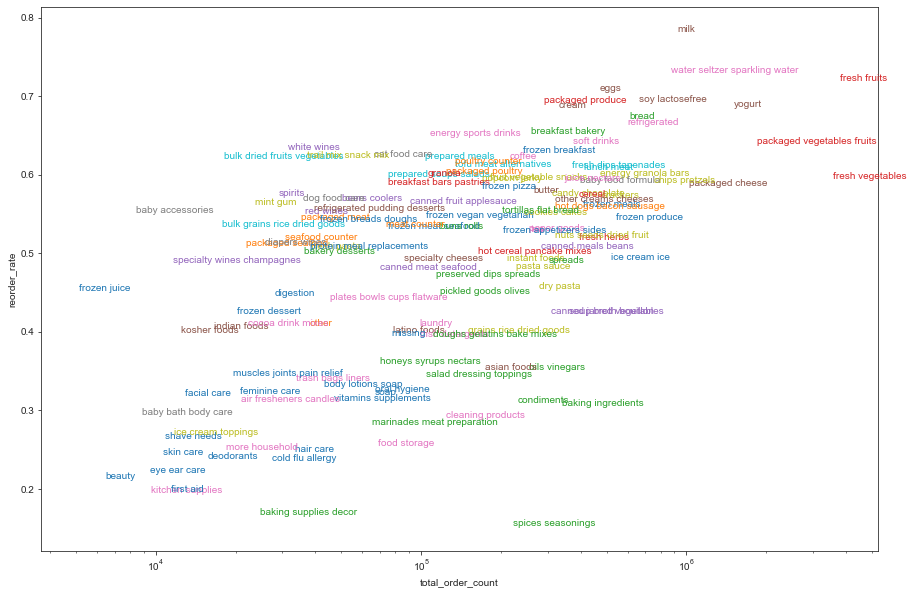

In [20]:
plt.figure(figsize=(15, 10))
fig = sns.regplot(data=df, x='total_order_count', y='reorder_rate',
                  scatter_kws={'alpha':0}, fit_reg=False)
fig.set(xscale="log")

# 色分けのための色を用意
department_num = len(set(df['department_id']))
color_palette = sns.color_palette(n_colors=department_num)

# 商品棚名を図中にプロット
for idx, row in df.iterrows():
    department_id = row['department_id']
    aisle_name = row['aisle']
    total_order_count = row['total_order_count']
    reorder_rate = row['reorder_rate']
    fig.text(total_order_count, reorder_rate, aisle_name,
             size='medium', color=color_palette[department_id-1])